Find the ground state of water molecule H2O

Steps involved are as below. 
- Create electronic structure problem for the water molecule. 
- Convert the problem to second quantization format using anhilisation and creation operators for each molecular orbit. 
- Convert Fermionic op to qubit hamiltonian
- Reduce the size of qubits required using ActiveSpaceTransformer. 
- Run VQE to find the ground state energy. 

In [145]:
from qiskit.quantum_info import SparsePauliOp
from qiskit import *
from qiskit.algorithms.minimum_eigensolvers import VQE 
from qiskit.algorithms.optimizers import SLSQP 
from qiskit.circuit.library import TwoLocal 
from qiskit.quantum_info import SparsePauliOp 
from qiskit.primitives import Estimator 
import numpy as np 
from qiskit_nature.units import DistanceUnit
from qiskit_nature import settings
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

settings.tensor_unwrapping = False
settings.use_pauli_sum_op = False

- Create electronic structure problem ffor the water molecule. 

In [146]:
driver = PySCFDriver(atom='O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0', unit=DistanceUnit.ANGSTROM, charge=0, spin=0, basis='sto3g')
electronic_structure_problem = driver.run()

print('Electonic structue problem (Molecule) ')
print(electronic_structure_problem.molecule)
print('(Basis) = ', electronic_structure_problem.basis)
print('(num_spatial_orbitals) = ', electronic_structure_problem.num_spatial_orbitals)

Electonic structue problem (Molecule) 
Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Bohr
	Geometry:
		O	(0.0, 0.0, 0.0)
		H	(1.430522676295752, 1.1073795089951262, 0.0)
		H	(-1.430522676295752, 1.1073795089951262, 0.0)
	Masses:
		O	16
		H	1
		H	1
(Basis) =  ElectronicBasis.MO
(num_spatial_orbitals) =  7


- Convert the problem to second quantization format using anhilisation and creation operators for each molecular orbit. 

In [147]:
FermionicOpWithCoefficients = electronic_structure_problem.hamiltonian.second_q_op()
print("Number of spin orbitals:", FermionicOpWithCoefficients.num_spin_orbitals)

Number of spin orbitals: 14


- Convert Fermionic op to qubit hamiltonian

In [148]:
qubit_mapper = ParityMapper(num_particles=electronic_structure_problem.num_particles)
qubit_hamiltonian = qubit_mapper.map(FermionicOpWithCoefficients)

print(qubit_hamiltonian)
print('No of qubits required for the solution : ', qubit_hamiltonian.num_qubits)


SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIZX', 'IIIIIIIIIIIX', 'IIIIIIIIZXXX', 'IIIIIIIIIYXY', 'IIIIIIZXXXXX', 'IIIIIIIYXXXY', 'IIIIIIIIIIZZ', 'IIIIIIIIZXXZ', 'IIIIIIIIIYYI', 'IIIIIIZXXXXZ', 'IIIIIIIYXXYI', 'IIIIIIIIIZZI', 'IIIIIIXXXXZI', 'IIIIIIYXXYII', 'IIIIIIIIZZII', 'IIIIIIZXXZII', 'IIIIIIIYYIII', 'IIIIIIIZZIII', 'IIIIIIZZIIII', 'IIIIIIZIIIII', 'IIIIIZIIIIII', 'IIIIZXIIIIII', 'IIIIIXIIIIII', 'IIZXXXIIIIII', 'IIIYXYIIIIII', 'ZXXXXXIIIIII', 'IYXXXYIIIIII', 'IIIIZZIIIIII', 'IIZXXZIIIIII', 'IIIYYIIIIIII', 'ZXXXXZIIIIII', 'IYXXYIIIIIII', 'IIIZZIIIIIII', 'XXXXZIIIIIII', 'YXXYIIIIIIII', 'IIZZIIIIIIII', 'ZXXZIIIIIIII', 'IYYIIIIIIIII', 'IZZIIIIIIIII', 'ZZIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIIIIIIIZI', 'IIIIIIIIZXXI', 'IIIIIIIIIYYZ', 'IIIIIIZXXXXI', 'IIIIIIIYXXYZ', 'IIIIIIIIZXYY', 'IIIIIIIIIYYX', 'IIIIIIZXXXYY', 'IIIIIIIYXXYX', 'IIIIIIXXXYIY', 'IIIIIIXXXXIX', 'IIIIIIYXXYZX', 'IIIIIIXXXXZX', 'IIIIIIYXXYIX', 'IIIIIIYXXXIY', 'IIIIIIZXYIIY', 'IIIIIIZXXZZX', 'IIIIIIIYYIZX', 'IIIIIIZX

- Use active space transformer to convet the qubit requirement to 4.

In [149]:
# Activate space transformer
active_space_transformer = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=3)
electronic_structure_problem = active_space_transformer.transform(electronic_structure_problem)
qubit_mapper = ParityMapper(num_particles=electronic_structure_problem.num_particles)
qubit_hamiltonian = qubit_mapper.map(electronic_structure_problem.hamiltonian.second_q_op())
print('No of qubits required for the solution : ', qubit_hamiltonian.num_qubits)


No of qubits required for the solution :  4


In [150]:
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver, MinimumEigensolverResult
from qiskit.primitives import Estimator


- Find the initial state to be fed into the VQE and ansatz

In [151]:
initial_state = HartreeFock(
    num_spatial_orbitals=electronic_structure_problem.num_spatial_orbitals, 
    num_particles=electronic_structure_problem.num_particles, 
    qubit_mapper=qubit_mapper)

ansatz = UCCSD(
    num_spatial_orbitals=electronic_structure_problem.num_spatial_orbitals, 
    num_particles=electronic_structure_problem.num_particles, 
    qubit_mapper=qubit_mapper, 
    initial_state=initial_state)

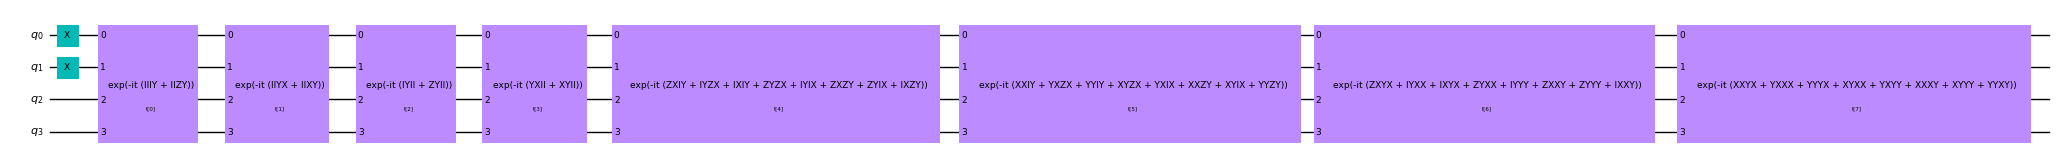

In [152]:
ansatz.decompose().draw(output="mpl", scale=0.5, fold=100)

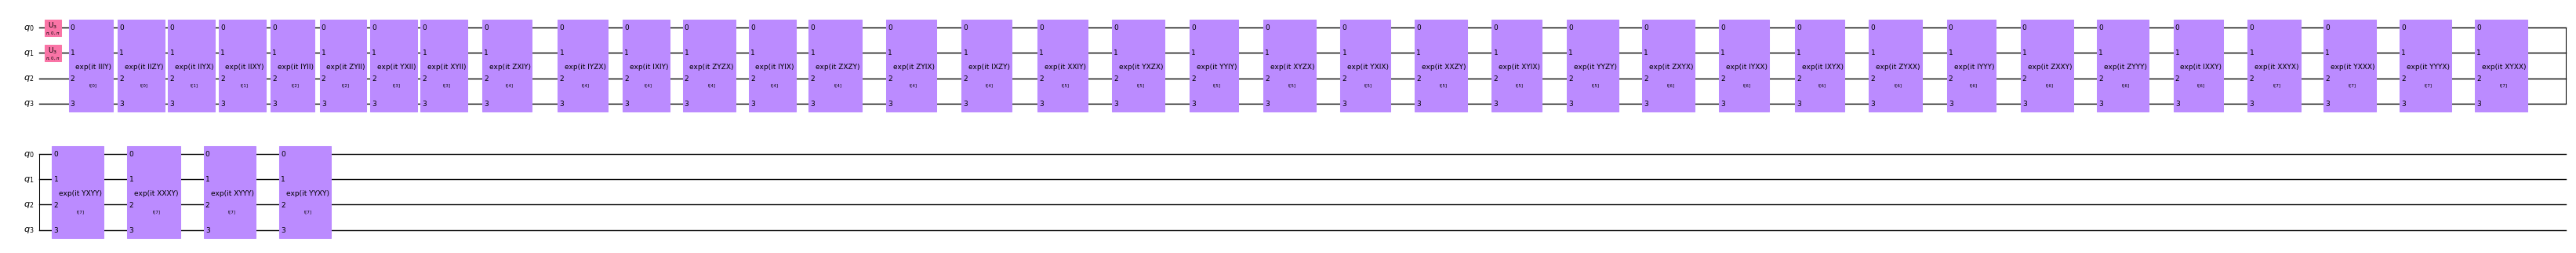

In [153]:
ansatz.decompose().decompose().draw(output="mpl", scale=0.5, fold=100)

In [154]:
# Setup optimizer
optimizer = COBYLA(maxiter=2500)

energies = []
def callback(nfev, x, fx, *args):
    energies.append(fx)

# Setup VQE
estimator = Estimator()
vqe_solver = VQE(estimator, ansatz, optimizer, callback=callback)

In [155]:
# Solve for the groundstate
result = vqe_solver.compute_minimum_eigenvalue(qubit_hamiltonian)
result = electronic_structure_problem.interpret(result)

print (result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.158406511586
  - computed part:      -1.664191485878
  - ActiveSpaceTransformer extracted energy part: -82.494215025708
~ Nuclear repulsion energy (Hartree): 9.193913160623
> Total ground state energy (Hartree): -74.964493350962
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  2.21475902  0.0]
 


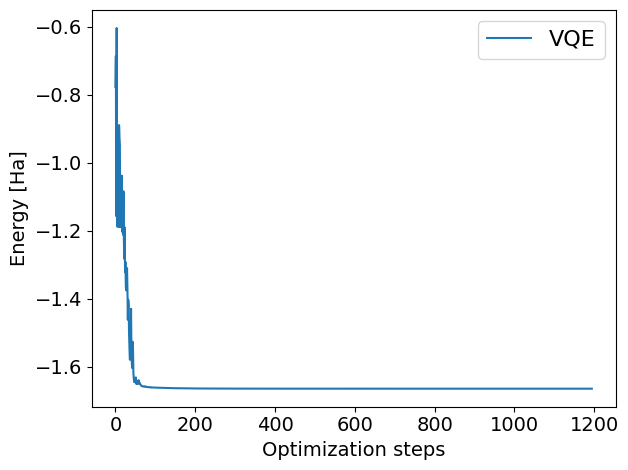

In [156]:
import matplotlib.pyplot as plt

plt.plot(energies, label='VQE')

plt.ylabel('Energy [Ha]', fontsize=14)
plt.xlabel('Optimization steps', fontsize=14)

plt.tick_params(which='both', labelsize=14)
plt.legend(fontsize=16)
plt.tight_layout()